In [9]:
import cluster_model
MODEL_NAME = 'EleutherAI/pythia-70m'
DATASET_NAME = 'NeelNanda/pile-10k'
MIXTURE_MODEL_TYPE = "KMenas"
# 
N_DIMS = 512
SEED = 69_420
# 
DEBUG = False
# 
if DEBUG:
    N_DATASIZE = 200
    N_CLUSTERS_MIN = 20
    N_CLUSTERS_MAX = 21
    N_BLOCKS = 6
    STRING_SIZE_CUTOFF = 200
else:
    # It gets killed aroun 1_800 idk why. Maybe we have a problem with token truncation somewhere
    N_DATASIZE = 1_800
# 
    # N_CLUSTERS_MIN = int(0.5 * N_DIMS)
    # N_CLUSTERS_MAX = 10 * N_DIMS
    # TODO: DEL ME
    N_CLUSTERS_MIN = N_DIMS
    N_CLUSTERS_MAX = N_DIMS + 1
    N_BLOCKS = 6
    STRING_SIZE_CUTOFF = 1_200

params = cluster_model.InterpParams(
	lattice_params=cluster_model.LatticeParams(
		top_layer_idx = -1,
        max_n_parents = 4
	),
    # quantization='4bit',
	seed=SEED,
    n_datasize=N_DATASIZE,
    n_blocks=N_BLOCKS,
    model_name=MODEL_NAME,
	model_n_dims=N_DIMS,
    dataset_name=DATASET_NAME,
    string_size_cutoff=STRING_SIZE_CUTOFF,
    quantization='4bit'
)

decomp = cluster_model.Decomposer(params)

Creating decomposer with parameter data hash metadata/data-2d2fdedfff35e3dd9c277c71e0d9221ab34f1d69/start.pkl
Creating decomposer with parameter lattice hash metadata/correlation-8a54ca0a541e764ad00f25c2bf884c2cac448157/start.pkl
Created dataset
Loading dataset from cache
Got embeddings


In [10]:
decomp.load()

Loading cluster scores from cache
Using saved correlation for layer 0
Using saved correlation for layer 1
Using saved correlation for layer 2
Using saved correlation for layer 3
Using saved correlation for layer 4
Using saved correlation for layer 5


## Try Clique Method

In [11]:
decomp.internal_correlations[0].shape, decomp.ds_emb[0].shape

((1024, 1024), (457525, 512))

In [12]:
import importlib
import simplex
import pickle
import os
importlib.reload(simplex)

p = 'tmp_for_clique_list.pkl'
if os.path.exists(p):
    clique_lists = pickle.load(open(p, 'br'))
else:
    clique_lists = []
    for layer in range(params.n_blocks):
        print("STARTING LAYER", layer)
        clique_lists.append(simplex.find_high_weight_faces(decomp.internal_correlations[layer], 
                                                           decomp.ds_emb[layer]))
        print(clique_lists[-1])
    pickle.dump(clique_lists, open('tmp_for_clique_list.pkl', "bw+"))

In [13]:
import numpy as np
importlib.reload(simplex)

if os.path.exists('face_corr_0.npy'):
	face_corr = [
        np.load(f'face_corr_{i}.npy')  for i in range(5)
    ]
else:
    face_corr = simplex.face_correlation_lattice(decomp.internal_correlations, clique_lists)
# pickle.dump(clique_lists, open('tmp_for_clique_corrs.pkl', "bw+"))

In [17]:
import graph
import pickle
import networkx as nx
importlib.reload(graph)

# Hrmmmm.... this type of "disentanglement may just be too harsh?? Or is the harshness a good thing?"
# Hrmmm clearly we need an "all positive thing" going on...
# TODO: there has got to be a way to make this faster...

# TODO: this is too much memory!!! Just recreate using numpy...
if not os.path.exists('tmp_G.pkl'):
    G = graph.GraphOfCorrs(face_corr, corr_cutoff=0.5)
    pickle.dump(G, open("tmp_G.pkl", "bw+"))
else:
    G = pickle.load(open('tmp_G.pkl', 'br'))

STARTING LAYER 0
FINISHED LAYER 0
STARTING LAYER 1
FINISHED LAYER 1
STARTING LAYER 2
FINISHED LAYER 2
STARTING LAYER 3
FINISHED LAYER 3
STARTING LAYER 4
FINISHED LAYER 4


In [18]:
list(G.node_idx_to_graph_idx[0].keys())[-10:]

[1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981]

In [21]:
importlib.reload(graph)

# path_inds = G.get_top_k_paths(0, 1, 10)
self = G
layer = 1
neuron = 1408
k = 10
path_inds = G.get_top_k_paths(layer, neuron, k, all_disjoint=True)

Looking for disjoint paths
([1634, 1408, 569, 568, 505, 923], 4.229817698116302)
([878, 1408, 779, 775, 695, 1138], 4.197427698116302)
([1399, 1408, 500, 365, 324, 308], 4.179997698116303)
([26, 1408, 215, 6, 772, 753], 4.171647698116303)
([636, 1408, 216, 488, 999, 986], 4.163977698116303)
No path for neuron 1408


In [24]:
paths = [
    [clique_lists[layer][idx] for layer, idx in enumerate(p[0])] for p in path_inds
]
paths

[[(0.620127535617142, [850, 963, 836]),
  (0.6303180824504896, [732, 836]),
  (0.9969212099420198, [303, 46]),
  (0.8570283614477873, [303, 820]),
  (0.9663673730324278, [303, 113]),
  (0.8870953371731645, [546, 113])],
 [(0.6161604309150239, [465, 732]),
  (0.6303180824504896, [732, 836]),
  (0.999574490922473, [411, 312]),
  (0.7742860116736191, [411, 553]),
  (0.9939442610273341, [411, 312]),
  (0.0, [663])],
 [(0.6457819578062731, [732, 154, 913]),
  (0.6303180824504896, [732, 836]),
  (0.9996164830681354, [267, 312]),
  (0.9999458117401329, [195, 113]),
  (0.9623843709957698, [195, 113]),
  (0.8855546589761868, [195, 209])],
 [(0.632892347623543, [14, 255, 732]),
  (0.6303180824504896, [732, 836]),
  (0.9996885470720913, [115, 312]),
  (0.9999395192536676, [3, 113]),
  (0.9913849762233076, [457, 312]),
  (0.0, [457])],
 [(0.6334749579707878, [338, 255, 732]),
  (0.6303180824504896, [732, 836]),
  (0.9961570727443524, [115, 46]),
  (0.9999342364855978, [261, 113]),
  (0.99143843875

In [ ]:
import numpy as np
from typing import List
import numpy.typing as npt
import kernel


def score_face_path(embd_dataset: List[npt.NDArray], path: List[simplex.Face], layer: int, BS=1_024 * 64):

		# Faks
    def get_cutoff_for_layer(neuron: int, layer_to_cutoff: int):
        fs = kernel.feature_prob(embd_dataset[layer_to_cutoff], neuron)
        nonzeros = fs[np.where(fs > 0)]
        if len(nonzeros) == 0:
            return 0.0
        return sum(nonzeros) / len(nonzeros)


    n_tokens = embd_dataset[0].shape[0]
    rets = np.ones(n_tokens)

    for i in range(0, n_tokens, BS):
        top_idx = min(i+BS, n_tokens)
        for curr_layer in range(len(path)):
            per_node_score = None
            n_nonzero_on = np.zeros(top_idx - i)
            curr_len = len(path[curr_layer])
            for node in path[curr_layer]:
                # TODO: func out because messy
                # multiplier = -1 if node % 2 == 1 else 1
                # selector = node // 2
                local_scores = kernel.feature_prob(embd_dataset[curr_layer][i:top_idx], node)
                n_nonzero_on += (local_scores > 0)
                # local_scores = kernel.feature_prob(embd_dataset[curr_layer][i:top_idx], node)
                per_node_score = local_scores if per_node_score is None else per_node_score * local_scores
            # print(layer, curr_layer, per_node_score)
            # rets[i:top_idx] *= per_node_score * (per_node_score > 0) if layer == curr_layer else (per_node_score > 0.3)
            # print((n_nonzero_on >= curr_len).sum(), layer, curr_layer)

            rets[i:top_idx] *= (per_node_score * (per_node_score > 0) if layer == curr_layer \
                else (n_nonzero_on >= (curr_len)))
    return rets

ret = score_face_path(decomp.ds_emb, path[:3], layer=layer)
print("ZERO COMPS", ret.nonzero()[0].shape, ret.shape, ret.nonzero()[0].shape[0] / ret.shape[0])

ZERO COMPS (2800,) (459325,) 0.0060959015947313995


In [ ]:
embeds, token_to_original_ds, _ = decomp._get_ds_metadata(
    decomp.dataset, decomp.ds_emb)
item_to_scores = {}
# return log_scores
# TODO: BATCHING!
for i in range(len(ret)):
    item = token_to_original_ds[i]
    if item not in item_to_scores:
        item_to_scores[item] = []
    item_to_scores[item].append(ret[i])
# Assuming that the scores are "dense" in how they were added, we have a list
ks = sorted(list(item_to_scores.keys()))
final_scores = []
for k in ks:
    s = item_to_scores[k]
    final_scores.append(s)

BOS_TOKEN = '||BOS||'
scores_per_token_set = np.array([max(s) for s in final_scores])
top_args = np.argsort(scores_per_token_set)[::-1][:100]
# TODO: BOS?
tokens = [[BOS_TOKEN] + [decomp.model.tokenizer.decode(t) for t in decomp.model.tokenizer(d)[
    'input_ids']] for d in decomp.dataset]
tokens_reord = [tokens[i] for i in top_args]

scores_reord = [final_scores[i] for i in top_args]
import visualization
visualization.save_display_for_neuron([(tokens_reord, scores_reord)], paths=[path], layer=0, neuron=1)

## Try looking at internal sub-cliques

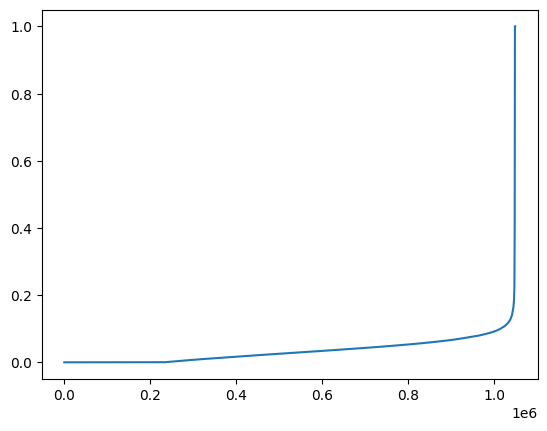

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
LY=0
f = decomp.internal_correlations[LY].flatten()
f.sort()
plt.plot(f)

In [ ]:
g_mat = decomp.internal_correlations[LY] * (decomp.internal_correlations[LY] > 0.05)

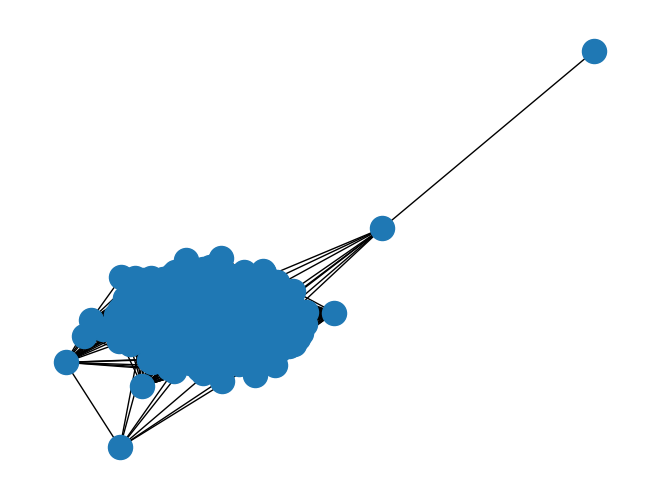

In [ ]:
for i in range(len(g_mat)):
	g_mat[i, i] = 0
g = nx.from_numpy_array(g_mat, edge_attr='weight')
nx.draw(g)

In [ ]:
g.edges(data=True)

EdgeDataView([(0, 2, {'weight': 0.060642180737723754}), (0, 3, {'weight': 0.0578702117492977}), (0, 6, {'weight': 0.06333659308799475}), (0, 9, {'weight': 0.10590038405893669}), (0, 10, {'weight': 0.07499151248701104}), (0, 13, {'weight': 0.05166956655489015}), (0, 14, {'weight': 0.05181781805421179}), (0, 17, {'weight': 0.07366903328427966}), (0, 19, {'weight': 0.08005050884556941}), (0, 22, {'weight': 0.07884264000958932}), (0, 32, {'weight': 0.06954445552646686}), (0, 35, {'weight': 0.06522215881901676}), (0, 40, {'weight': 0.07588154083392117}), (0, 41, {'weight': 0.062408693459924953}), (0, 45, {'weight': 0.05272818821727835}), (0, 48, {'weight': 0.08095117680430594}), (0, 50, {'weight': 0.0786679242385479}), (0, 54, {'weight': 0.08666634664869198}), (0, 57, {'weight': 0.054888434356315394}), (0, 59, {'weight': 0.09213820422878354}), (0, 61, {'weight': 0.06562591797285766}), (0, 69, {'weight': 0.06165904521667771}), (0, 70, {'weight': 0.053166749832105585}), (0, 73, {'weight': 0.0

In [ ]:
from typing import List
LIM = 100
cliques_per_node = []
for N in range(1024):
    # print("Getting clique centered at", N)
    cliques_per_node.append([])
    y = nx.find_cliques(g, nodes=[N])
    for i, conns in enumerate(y):
        # print(conns)
        cliques_per_node[-1].append(conns)
        if i >= LIM:
            break

KeyboardInterrupt: 

In [ ]:
import numpy as np

weight_attrs = nx.get_edge_attributes(g, 'weight')
n_tops = 20

def get_avg_clique_weight(clique: List[int]):
    total_weight = 0
    total_cons = 0
    # if len(clique) > 15:
    #     return 0
    # print("GET AVG", len(clique))
    for i in range(len(clique)):
        for j in range(i):
            total_cons += 1
            o = [clique[i], clique[j]]
            o.sort()
            o = tuple(o)
            total_weight += weight_attrs[o]
    return  total_weight / (total_cons ** 2)

top_cliques_per_node = []
for node, cliques in enumerate(cliques_per_node):
    top_cliques_per_node.append([])
    # print("Looking at node", node)
    weights = np.array([get_avg_clique_weight(c) for c in cliques])
    # cliques_per_node[node] = zip(weights, cliques)
    tops = np.argsort(weights)[::-1]
    n = min(len(tops), n_tops)
    for i in range(n):
        # print(tops[i], cliques[tops[i]], weights[tops[i]])
        top_cliques_per_node[-1].append((weights[tops[i]], cliques[tops[i]]))

In [ ]:
top_cliques_per_node[116]

[(0.00476589816306355, [116, 1, 96, 206, 409, 127]),
 (0.004354197873774676, [116, 1, 96, 772, 127, 409]),
 (0.0037320873629422993, [116, 1, 96, 772, 127, 578, 338]),
 (0.003401880802542858, [116, 1, 96, 608, 578, 338, 206, 127]),
 (0.003091127467289876, [116, 1, 96, 538, 578, 394, 533, 338]),
 (0.0030801649334375254, [116, 1, 96, 613, 826, 625, 951, 571]),
 (0.0028471196873572665, [116, 1, 96, 613, 578, 951, 625, 822]),
 (0.002806223494763614, [116, 1, 96, 538, 578, 394, 776, 338]),
 (0.0028059565592186164, [116, 1, 96, 613, 578, 951, 625, 571]),
 (0.0027932091022759434, [116, 1, 96, 538, 578, 338, 776, 127]),
 (0.0027540870410381595, [116, 1, 96, 613, 578, 131, 625, 822]),
 (0.0027302890627161638, [116, 1, 96, 613, 578, 338, 127, 776]),
 (0.002695488497679447, [116, 1, 96, 613, 578, 131, 776, 501]),
 (0.0026841041360351854, [116, 1, 96, 538, 776, 18, 127, 338]),
 (0.0026810120637260526, [116, 1, 96, 608, 578, 338, 206, 533, 1005]),
 (0.0026240922513907938, [116, 1, 96, 613, 578, 951,

## Keep going

In [ ]:
from typing import List
import importlib
import utils
importlib.reload(utils)
# modified_lattice = decomp.correlation_scores.copy()

# # TODO: have function which does something like fixing from the a specific neuron?
# # Ie have the sub-lattice with only **related** neurons

# def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
#     print(lattice[0].sum())
#     r = [(layer > related_cutoff) * layer for layer in lattice]
#     print(r[0].sum())
#     return r

# def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
# 	with_cutoff = cutoff_lattice(lattice, related_cutoff)

# LAST_FEAT = 20
# modified_lattice = cutoff_lattice(decomp.correlation_scores, related_cutoff=15)

# # utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

<module 'utils' from '/home/lev/code/research/ai/lattice_cluster_paths/utils.py'>

## Isolate Specific Neurons

In [ ]:
LAYER = 0
NEURON = 128

In [ ]:
import numpy as np
import kernel
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
import graph
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(graph)
importlib.reload(kernel)

N_CHECK = 4

# decomp.scores_for_neuron(LAYER, NEURON, n_features_per_neuron=3)

/tmp/ipykernel_14585/2553305548.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

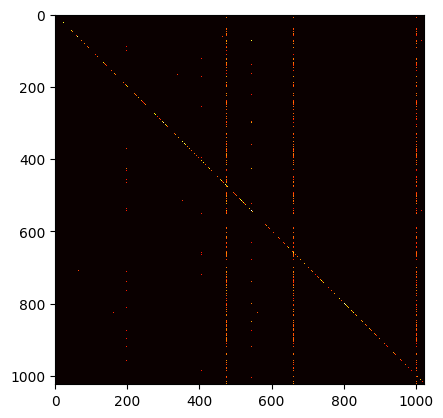

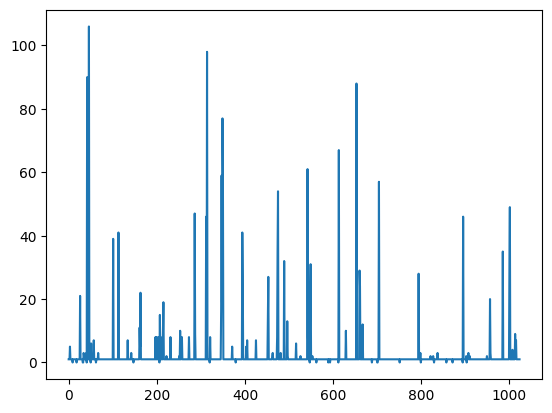

In [ ]:
import matplotlib.pyplot as plt

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.3

# ax = sns.heatmap(decomp.correlation_scores[LAYER_START])
plt.imshow(decomp.correlation_scores[LAYER_START] * (decomp.correlation_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.correlation_scores[3] > cutoff).sum(axis=1))

## Lets look at the distribution of internal correlations

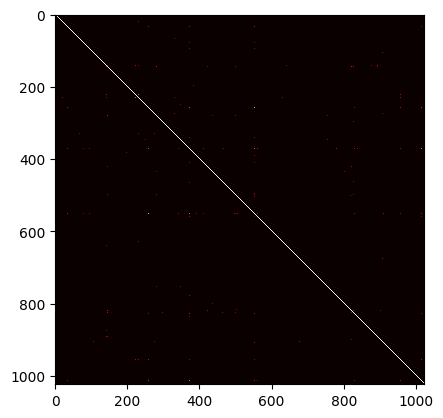

In [ ]:
cutoff = 0.2
plt.imshow(decomp.internal_correlations[0] * (decomp.internal_correlations[0] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

## Look at the distribution of scores. Is there someway to figure out what the "inclusion cutoff" should be?

##

13 459325


([<matplotlib.lines.Line2D at 0x738c625b1580>],
 0.1775552987148854,
 0.3140376880331719)

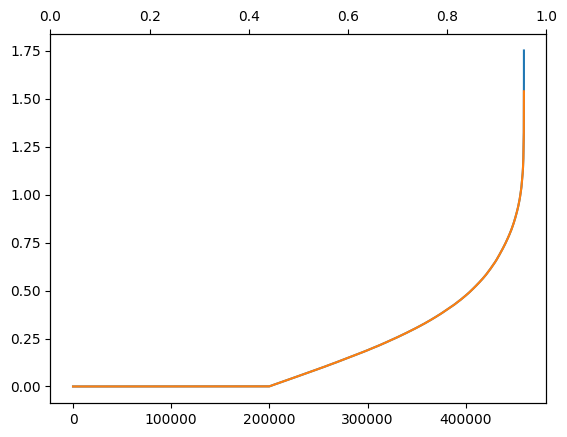

In [ ]:
import math

feat = (1, 497)
fs = kernel.feature_prob(decomp.ds_emb[feat[0]], feat[1])
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
fs.sort()

ax1.plot(fs)
log_idx = int(round( math.log(len(fs))))
print(log_idx, len(fs))
nonzeros = fs[np.where(fs > 0)]
ax1.plot(fs[:-log_idx]), sum(fs) / len(fs), sum(nonzeros) / len(nonzeros)


## Get scores for layers

In [ ]:
!rm metadata/correlation-de5f2c593b55f095d11e400fd8f6d0964dc8512c/layer_0_neuron_*

rm: cannot remove 'metadata/correlation-de5f2c593b55f095d11e400fd8f6d0964dc8512c/layer_0_neuron_*': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
importlib.reload(graph)
decomp.scores_for_layer(0)

WEIGHTING PER LAYER [1.      0.8     0.64    0.512   0.4096  0.32768]
EDGE DISCOVERY WEIGHTING PER LAYER [1. 1. 1. 1. 1.]
Getting top 7 paths


NameError: name 'top_k_dag_paths' is not defined

In [ ]:
# TODO: LAYER 0 and NEURON 112... I think that its actually no path on the downstream?
decomp.scores_for_layer(4)

WEIGHTING PER LAYER [0.4096 0.512  0.64   0.8    1.     0.8   ]
EDGE DISCOVERY WEIGHTING PER LAYER [1. 1. 1. 1. 1.]
Getting top 7 paths
Looking for disjoint paths
([753, 753, 753, 753, 0, 1], 3.2629518189164104)
([753, 753, 753, 753, 0, 474], 3.1815818189164107)
([753, 753, 753, 753, 0, 346], 3.1770118189164105)
([753, 753, 753, 753, 0, 197], 3.1519818189164104)
([753, 753, 753, 753, 0, 395], 3.1515518189164107)
([753, 753, 753, 753, 0, 660], 3.1288818189164105)
([753, 753, 753, 753, 0, 1000], 3.1264118189164103)
Got top 7 paths
Paths for neuron 0 [([753, 753, 753, 753, 0, 1], 3.2629518189164104), ([753, 753, 753, 753, 0, 474], 3.1815818189164107), ([753, 753, 753, 753, 0, 346], 3.1770118189164105), ([753, 753, 753, 753, 0, 197], 3.1519818189164104), ([753, 753, 753, 753, 0, 395], 3.1515518189164107), ([753, 753, 753, 753, 0, 660], 3.1288818189164105)]
Finished for neuron 4 0
WEIGHTING PER LAYER [0.4096 0.512  0.64   0.8    1.     0.8   ]
EDGE DISCOVERY WEIGHTING PER LAYER [1. 1. 1. 1.

KeyboardInterrupt: 